# A2C


#### This version uses stable baseline A2C using a custom enviroment (unit 6)

In [ ]:
!pip install yfinance

# install talib in colab
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib as ta

In [44]:


import gym
from gym import spaces
from gym.utils import seeding
from gym import wrappers

from stable_baselines3 import A2C
from stable_baselines3.common.env_checker import check_env

from tqdm.notebook import tqdm
from collections import deque
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib

import talib as ta
import yfinance as yf
import pandas as pd

import io
import base64
from IPython.display import HTML, Video


In [45]:
from enum import Enum
class Actions(Enum):
    Sell = 0
    Buy = 1
    Do_nothing = 2

class CustTradingEnv(gym.Env):

    def __init__(self, df, max_steps=0, seed=8, random_start=True, scaler=None):
        self.seed(seed=seed)
        self.df = df
        if scaler is None:
            self.scaler = MinMaxScaler()
        else:
            self.scaler = scaler
        self.prices, self.signal_features = self._process_data()

        # spaces
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,) , dtype=np.float64)

        # episode
        self._start_tick = 0
        self._end_tick = 0
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None
        self._max_steps = max_steps
        self._start_episode_tick = None
        self._trade_history = None
        self._random_start = random_start


    def reset(self):
        self._done = False
        if self._random_start:
            self._start_episode_tick = np.random.randint(1,high=len(self.df)- self._max_steps )
            self._end_tick = self._start_episode_tick + self._max_steps
        else:
            self._start_episode_tick = 1
            self._end_tick = len(self.df)-1

        self._current_tick = self._start_episode_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = 0
        self._position_history = []
        # self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 0.
        self._trade_history = []
        self.history = {}
        return self._get_observation()


    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position,
            action = action
        )
        self._update_history(info)

        return observation, step_reward, self._done, info

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
        
    def _get_observation(self):
        return self.signal_features[self._current_tick]

    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


    def render(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        prices = self.prices[self._start_episode_tick:self._end_tick+1]
        plt.plot(prices)

        open_buy = []
        close_buy = []
        open_sell = []
        close_sell = []
        do_nothing = []

        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == 1:
                open_buy.append(tick)
            elif self._position_history[i] == 2 :
                close_buy.append(tick)
            elif self._position_history[i] == 3 :
                open_sell.append(tick)
            elif self._position_history[i] == 4 :
                close_sell.append(tick)
            elif self._position_history[i] == 0 :
                do_nothing.append(tick)

        plt.plot(open_buy, prices[open_buy], 'go', marker="^")
        plt.plot(close_buy, prices[close_buy], 'go', marker="v")
        plt.plot(open_sell, prices[open_sell], 'ro', marker="v")
        plt.plot(close_sell, prices[close_sell], 'ro', marker="^")
    
        plt.plot(do_nothing, prices[do_nothing], 'yo')

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

    def _calculate_reward(self, action):
        step_reward = 0

        current_price = self.prices[self._current_tick]
        last_price = self.prices[self._current_tick - 1]
        price_diff = current_price - last_price

        penalty = -1 * last_price * 0.01
        # OPEN BUY - 1
        if action == Actions.Buy.value and self._position == 0:
            self._position = 1
            step_reward += price_diff
            self._last_trade_tick = self._current_tick - 1
            self._position_history.append(1)

        elif action == Actions.Buy.value and self._position > 0:
            step_reward += penalty
            self._position_history.append(-1)
        # CLOSE SELL - 4
        elif action == Actions.Buy.value and self._position < 0:
            self._position = 0
            step_reward += -1 * (self.prices[self._current_tick -1] - self.prices[self._last_trade_tick]) 
            self._total_profit += step_reward
            self._position_history.append(4)
            self._trade_history.append(step_reward)

        # OPEN SELL - 3
        elif action == Actions.Sell.value and self._position == 0:
            self._position = -1
            step_reward += -1 * price_diff
            self._last_trade_tick = self._current_tick - 1
            self._position_history.append(3)
        # CLOSE BUY - 2
        elif action == Actions.Sell.value and self._position > 0:
            self._position = 0
            step_reward += self.prices[self._current_tick -1] - self.prices[self._last_trade_tick] 
            self._total_profit += step_reward
            self._position_history.append(2)
            self._trade_history.append(step_reward)
        elif action == Actions.Sell.value and self._position < 0:
            step_reward += penalty
            self._position_history.append(-1)

        # DO NOTHING - 0
        elif action == Actions.Do_nothing.value and self._position > 0:
            step_reward += price_diff
            self._position_history.append(0)
        elif action == Actions.Do_nothing.value and self._position < 0:
            step_reward += -1 * price_diff
            self._position_history.append(0)
        elif action == Actions.Do_nothing.value and self._position == 0:
            step_reward += -1 * abs(price_diff)
            self._position_history.append(0)

        return step_reward

    def get_scaler(self):
        return self.scaler

    def set_scaler(self, scaler):
        self.scaler = scaler
 
    def _process_data(self):
        timeperiod = 14
        self.df = self.df.copy()
        
        self.df['mfi_r'] = ta.MFI(self.df['High'], self.df['Low'], self.df['Close'],self.df['Volume'], timeperiod=timeperiod)
        _, self.df['stoch_d_r'] = ta.STOCH(self.df['High'], self.df['Low'], self.df['Close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
        self.df['adx_r'] = ta.ADX(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=timeperiod)
        self.df['p_di'] = ta.PLUS_DI(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=timeperiod)
        self.df['m_di'] = ta.MINUS_DI(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=timeperiod)
        self.df['di'] = np.where( self.df['p_di'] > self.df['m_di'], 1, 0)

        self.df = self.df.dropna()
        # self.df['di_s']=self.df['di']
        # self.df['mfi_s']=self.df['mfi_r']
        # self.df['stoch_d_s']=self.df['stoch_d_r']
        # self.df['adx_s']=self.df['adx_r']

        self.df[['di_s','mfi_s','stoch_d_s','adx_s']] = self.scaler.fit_transform(self.df[['di','mfi_r','stoch_d_r','adx_r']])

        def f1(row):
            row['state'] = [row['di_s'], row['mfi_s'], row['stoch_d_s'], row['adx_s']]
            return row

        self.df = self.df.apply(f1, axis=1 )

        prices = self.df.loc[:, 'Close'].to_numpy()
        # print(self.df.head(30))

        signal_features = np.stack(self.df.loc[:, 'state'].to_numpy())

        return prices, signal_features

In [33]:
# Get data
eth_usd = yf.Ticker("ETH-USD")
eth = eth_usd.history(period="max")

btc_usd = yf.Ticker("BTC-USD")
btc = btc_usd.history(period="max")
print(len(btc))
print(len(eth))

btc_train = eth[-3015:-200]
# btc_test = eth[-200:]
eth_train = eth[-1864:-200]
eth_test = eth[-200:]
# len(eth_train)

3074
1925


In [46]:
# create env
max_steps = 20  
env = CustTradingEnv(df=eth_train, max_steps=max_steps)

# check_env(env)

model = A2C("MlpPolicy", env, verbose=1)
# model.learn(total_timesteps=1000)
model.learn(total_timesteps=1_000_000)
model.save("./alt/a2c_tradeenv-100")

env.close()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 20       |
|    ep_rew_mean        | -43.8    |
| time/                 |          |
|    fps                | 910      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.1     |
|    explained_variance | -0.0217  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 13.9     |
|    value_loss         | 236      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 20       |
|    ep_rew_mean        | -89.3    |
| time/                 |          |
|    fps                | 901      |
|    iterations         | 200      |
|    time_elapsed 

In [47]:
joblib.dump(env.get_scaler(),"./alt/fin_rl_a2c_100_v1.h5_scaler")

['./alt/fin_rl_a2c_100_v1.h5_scaler']

In [48]:


def evaluate_agent(env, max_steps, n_eval_episodes, model, random=False):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param model: The A2C model
  """
  episode_rewards = []
  episode_profits = []
  for episode in range(n_eval_episodes):
#   for episode in tqdm(range(n_eval_episodes), disable=random):
    state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
    total_profit_ep = 0
    
    for step in range(max_steps):
      # Take the action (index) that have the maximum expected future reward given that state
      if random:
        action = env.action_space.sample()
      else:
        action, _states = model.predict(state)
        # action = model.play(state)
    # print(action)
        
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward
        
      if done:
        break
      state = new_state

    episode_rewards.append(total_rewards_ep)
    episode_profits.append(env.history['total_profit'][-1])
    # print(env.history)
    # env.render()
    # assert 0

  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)
  mean_profit = np.mean(episode_profits)
  std_profit = np.std(episode_profits)

  return mean_reward, std_reward, mean_profit, std_profit

In [49]:
# trade with random start in the test set 
max_steps = 20 
env_test = CustTradingEnv(df=eth_test, max_steps=max_steps, random_start=True, scaler=env.get_scaler())
n_eval_episodes = 1000

evaluate_agent(env_test, max_steps, n_eval_episodes, model)

(-59.88053379638672, 247.5485386506795, 61.646527954101565, 134.4789860013969)

In [50]:
# trade sequentially in the test set
max_steps = len(eth_test)
env_test = CustTradingEnv(df=eth_test, max_steps=max_steps, random_start=False, scaler=env.get_scaler())
n_eval_episodes = 1

evaluate_agent(env_test, max_steps, n_eval_episodes, model)

(52.61416015624997, 0.0, 734.18408203125, 0.0)

In [51]:
# load model and scaler from file
max_steps = 20 
scaler_l = joblib.load("./alt/fin_rl_a2c_100_v1.h5_scaler")
env_l = CustTradingEnv(df=eth_test, max_steps=max_steps, scaler=scaler_l, random_start=False)

model_l = A2C.load("./alt/a2c_tradeenv-100")


In [52]:
# trade sequentially the loaded model and env
max_steps = len(eth_test)
n_eval_episodes = 1
evaluate_agent(env_l, max_steps, n_eval_episodes, model_l)

(-149.75144287109362, 0.0, 945.44189453125, 0.0)

/var/folders/r6/jgl8b48s325fbkg5jwkg93fc0000gn/T/ipykernel_98524/1075875040.py:120: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(open_buy, prices[open_buy], 'go', marker="^")
/var/folders/r6/jgl8b48s325fbkg5jwkg93fc0000gn/T/ipykernel_98524/1075875040.py:121: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(close_buy, prices[close_buy], 'go', marker="v")
/var/folders/r6/jgl8b48s325fbkg5jwkg93fc0000gn/T/ipykernel_98524/1075875040.py:122: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(open_sell, prices[open_sell], 'ro', marker="v")
/var/folders/r6/jgl8b48s325fbkg5jwkg93fc0000gn/T/ipykernel_98524/1075875040.py:123: UserWarni

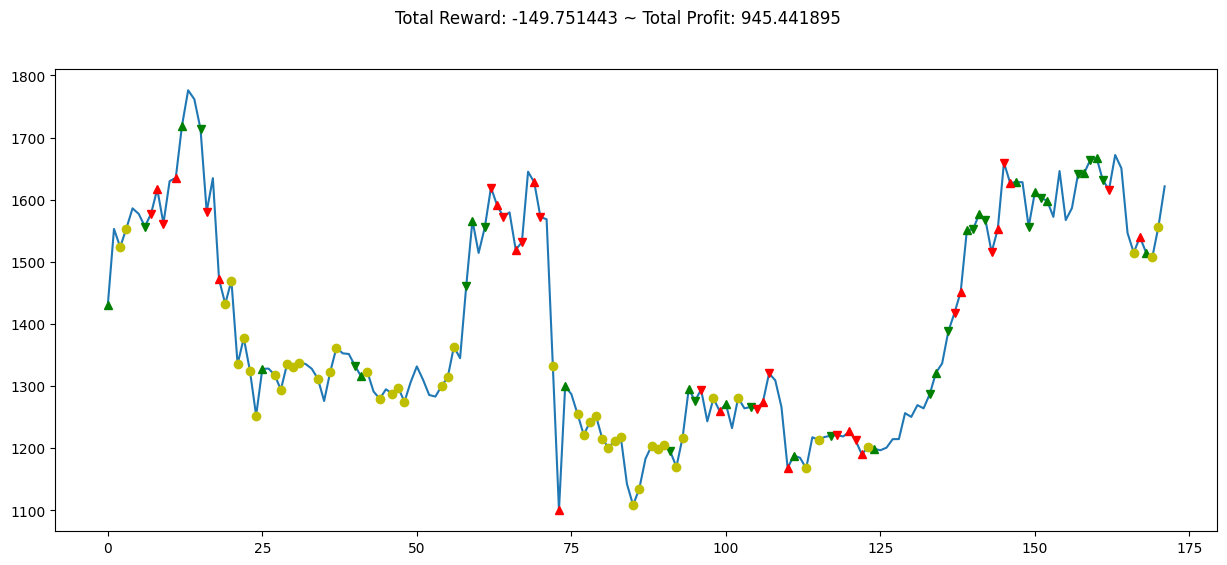

In [53]:
plt.figure(figsize=(15,6))
plt.cla()
env_l.render()


In [42]:
# Test for random n_eval_episodes
max_steps = 20 
env_test_rand = CustTradingEnv(df=eth_test, max_steps=max_steps, random_start=True, scaler=env.get_scaler())
n_eval_episodes = 1000

evaluate_agent(env_test_rand, max_steps, n_eval_episodes, model, random=True)

(-143.71849208740235,
 327.02519292656416,
 -2.4958328857421876,
 173.71400360701966)

In [43]:
# trade sequentially with random actions 
max_steps = len(eth_test)
env_test = CustTradingEnv(df=eth_test, max_steps=max_steps, random_start=False, scaler=env.get_scaler())
n_eval_episodes = 1

all_profit=[]
for i in range(1000):
    _,_,profit,_=evaluate_agent(env_test, max_steps, n_eval_episodes, model, random=True)
    all_profit.append(profit)
print(f"Mean profit {np.mean(all_profit)}")

Mean profit 22.493475219726562


## Results

| Model      | 1000 trades 20 steps | Sequential trading | 1000 trades 20 steps random actions | Sequential random|
|------------|----------------------|--------------------|-------------------------------------|------------------|
|Q-learning  | 113.14               | 563.67             | -18.10                              | 39.30            |
|DQN         | 87.62                | 381.17             | 4.95                                | 3.77             |
|A2c         | 61.64                | 734.18             | -2.49                               | 22.49            |

#### Actions are: Buy/Sell/Hold 1 ETH 
##### Model trading
1000 trades 20 steps - Made 1000 episodes, 20 trades each episode, result is the mean return of each episode 

Sequential trading (175 days)- Trade the test set sequentially from start to end day 
##### Random trading (to compare against model trading)
1000 trades 20 steps random actions - Made 1000 episodes, 20 trades each episode taking random actions 

Sequential random (175 days)- Trade the test set sequentially from start to end day with random actions 

In [57]:
env_l._trade_history

[126.3253173828125,
 -39.5416259765625,
 -73.59912109375,
 -5.3201904296875,
 109.094482421875,
 4.8367919921875,
 146.1649169921875,
 -11.0887451171875,
 28.9151611328125,
 53.002685546875,
 -96.42626953125,
 472.06494140625,
 -104.337646484375,
 -19.4146728515625,
 34.6265869140625,
 -5.2696533203125,
 -10.75048828125,
 152.289794921875,
 32.0098876953125,
 -5.8258056640625,
 22.8055419921875,
 88.126708984375,
 66.393798828125,
 -33.6763916015625,
 1.7725830078125,
 -8.9874267578125,
 -37.049560546875,
 32.635986328125,
 -71.77783203125,
 -8.6051025390625,
 43.63623046875,
 21.5040283203125,
 -35.413330078125,
 76.3203125]